### Description: Sparse Bayesian learning
#### Assumptions: scalar input, scalar output

###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import os, math, sys

Assign polynomial basis (polyPower), hyper-parameters a,b,c,d and initial hyperparameter $\alpha$ and noise precision $\rho$:

In [2]:
poly0 = [0,1,2,3,4,5,6] # powers of polynomial basis
N = len(poly0) # number of coefficients 
Wlim = [-5,5]
Nsbl = 50

Generate design matrix $\Phi$, and load observations $Y$ and input $X$: 

In [3]:
def getPhiMat(X,polyPower):
    M = len(X)
    Phi = np.zeros((M,N))
    for i in range(0,M):
        for j in range(0,N): Phi[i,j] = X[i]**polyPower[j]
    return Phi
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
PhiAll = getPhiMat(Xobs,poly0)
M = len(Yobs)

Sparse Bayesian leanring through Mackay's algorithm (similar to expectation maximizations):

In [4]:
def update_SBL(iGammaAll,iGammaProp,iSlopeLogEvid,iCheckQsqS,iKLdist,imall,iRho,iLambda,iRhoFlag,printFlag):
    iN = np.count_nonzero(iGammaAll)
    iGamma = np.zeros((iN,1))
    iPhi  = np.zeros((M,iN))
    iParIndex = [int(0)]*iN
    ij=0
    for ii in range(0,N):
        if iGammaAll[ii,0] > 0.0: 
            iPhi[:,ij] = PhiAll[:,ii]
            iParIndex[ij] = ii
            iGamma[ij,0] = iGammaAll[ii,0]
            ij = ij +1
    iA    = np.diag(np.divide(1,iGamma[:,0]))
    iP    = np.linalg.inv(iA + iRho*np.matmul(np.transpose(iPhi),iPhi)) 
    im    = iRho*np.matmul(iP,np.matmul(np.transpose(iPhi),Yobs))
    ij=0
    for ii in range(0,N):
        if iGammaAll[ii,0] > 0: 
            imall[ii,0] = im[ij]
            iKLdist[ii,0] = 0.5*((iP[ij,ij] + im[ij]**2)/iGamma[ij,0] - 1 - np.log(iP[ij,ij]/iGamma[ij,0]))
            ij = ij +1
        else:
            imall[ii,0] = 0.0
            iKLdist[ii,0] = -1
    itemp = np.matmul(iPhi,np.matmul(iP,np.transpose(iPhi)))
    for j in range(0,N):
        iSbar = iRho*np.sum(PhiAll[:,j]**2) - (iRho**2)*np.matmul(np.transpose(PhiAll[:,j]),np.matmul(itemp,PhiAll[:,j])) 
        iQbar = iRho*np.matmul(np.transpose(PhiAll[:,j]),Yobs) - (iRho**2)*np.matmul(np.transpose(PhiAll[:,j]),np.matmul(itemp,Yobs))
        iS    = iSbar/(1-iGammaAll[j,0]*iSbar)
        iQ    = iQbar/(1-iGammaAll[j,0]*iSbar)
        iSlopeLogEvid[j,0] = ((iGammaAll[j,0]**2)*iLambda*(iS**2) + iGammaAll[j,0]*(iS**2 + 2*iLambda*iS) \
                              + iLambda - iQ**2 + iS)/(-2.0*(1.0 + iS*iGammaAll[j,0])**2)
        iGammaProp[j,0] = (-iS*(iS+2*iLambda) + iS*np.power((iS+2*iLambda)**2 - 4*iLambda*(iS-iQ**2+iLambda),0.5))/(2*iLambda*iS**2)
        iCheckQsqS[j,0] = iQ**2 - iS
    iLogEvid = np.log(st.multivariate_normal.pdf(Yobs,[0]*M,np.matmul(iPhi,np.matmul(np.linalg.inv(iA),np.transpose(iPhi))) + np.identity(M)/iRho))
    if (iRhoFlag == 1): 
        iRho =  (N)/np.sum((Yobs-np.matmul(iPhi,im))**2)
    iLambda = (N - 1)/(0.5*np.sum(iGamma))
    if printFlag == 1:
        print("#basis: {0:3d}, LogEvid : {1:11.2e}, Rho: {2:11.2e}, Lambda: {3:11.2e}".format(iN,iLogEvid,iRho,iLambda))
        print('      gamma       mean  slopeEvid     KLdist      Q^2-s')
        for i in range(0,N):
            print("{5:3d}{0:11.2e}{1:11.2e}{2:11.2e}{3:11.2e}{4:11.2e}".format(iGammaAll[i,0],imall[i,0],iSlopeLogEvid[i,0],iKLdist[i,0],iCheckQsqS[i,0],i))
    return iLogEvid,iRho,iParIndex

Run the sparse Bayesain learning loop to obtain optimal hyperparameter:

In [5]:
iterGamma = np.zeros((N,Nsbl))
iterMean = np.zeros((N,Nsbl))
iterLogEvid = [0]*Nsbl
iterRho = [0]*Nsbl
mVec          = np.zeros((N,1))
Gamma         = 100*np.ones((N,1))
GammaProp     = np.zeros((N,1))
slopeLogEvid  = np.zeros((N,1))
KLdist        = 100*np.zeros((N,1))
checkQsqS     = np.zeros((N,1))
maxSBLiter = 50
Rho    = 20
Lambda = 0.001
prevLogEvid = 0.0
LogEvid = 0.0
tolGamma = 1e-30
tolSlope = 1e-08
prevInd = 0
curInd = 0
curIndList = [0]
rhoFlag= 1
printFlag = 0
convergeFlag = 0
i = 0
LogEvid, Rho, curIndList = update_SBL(Gamma,GammaProp,slopeLogEvid,checkQsqS,KLdist,mVec,Rho,Lambda,rhoFlag,printFlag)
while convergeFlag == 0:
    if i > N-1:
        if i%3 ==0:
            curInd = np.random.randint(0,N)
        else:
            if max(slopeLogEvid[:,0]) > tolSlope:
                curInd = np.argmax(slopeLogEvid[:,0])
            #else:
                #convergeFlag = 1
                #print('Slope is zero for all alpha!')
    else:
        curInd = i
    curInd = np.random.randint(0,N)
    if i > Nsbl-2: 
        convergeFlag = 1
        print('Maximum SBL iteration reached!')

    prevLogEvid = LogEvid
    curGamma = GammaProp[curInd,0]
    if (checkQsqS[curInd,0] > Lambda  and curGamma > tolGamma):
        if    Gamma[curInd,0] == 0: 
            Gamma[curInd,0] = curGamma
            curText = 'Add    '
        else: 
            Gamma[curInd,0] = curGamma
            curText = 'Update '
    else:
        if Gamma[curInd,0] == 0: 
            curText = 'Neglect'
        else: 
            Gamma[curInd,0] = 0.0
            curText = 'Remove '
    #print(i,'-------Try ',curInd,': ',curText)
    LogEvid, Rho, curIndList = update_SBL(Gamma,GammaProp,slopeLogEvid,checkQsqS,KLdist,mVec,Rho,Lambda,rhoFlag,printFlag)
    prevInd = curInd
    iterMean[:,i] = mVec[:,0]
    iterGamma[:,i] = Gamma[:,0]
    iterLogEvid[i] = LogEvid
    iterRho[i] = Rho
    i = i+1
Niter = i
print('End result:\n',curIndList,':',LogEvid,':',Rho)
LogEvid, Rho, curIndList = update_SBL(Gamma,GammaProp,slopeLogEvid,checkQsqS,KLdist,mVec,Rho,Lambda,rhoFlag,1)

Maximum SBL iteration reached!
End result:
 [0, 3] : -56.44727660430236 : 3.957166233308489
#basis:   2, LogEvid :   -5.64e+01, Rho:    3.96e+00, Lambda:    6.03e+00
      gamma       mean  slopeEvid     KLdist      Q^2-s
  0   9.86e-01   9.93e-01  -1.63e-11   3.33e+00   6.18e+05
  1   0.00e+00   0.00e+00  -2.20e+01  -1.00e+00  -4.41e+01
  2   0.00e+00   0.00e+00  -3.51e+01  -1.00e+00  -7.01e+01
  3   1.01e+00  -9.99e-01  -9.13e-15   2.39e+00   1.37e+04
  4   0.00e+00   0.00e+00  -2.80e+01  -1.00e+00  -5.60e+01
  5   0.00e+00   0.00e+00  -1.40e+00  -1.00e+00  -2.79e+00
  6   0.00e+00   0.00e+00  -2.25e+01  -1.00e+00  -4.49e+01


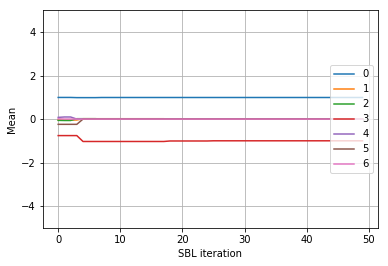

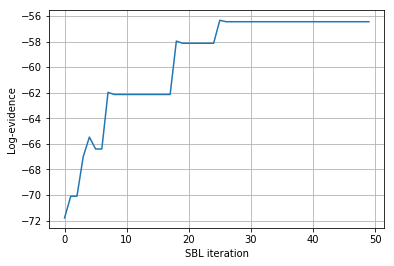

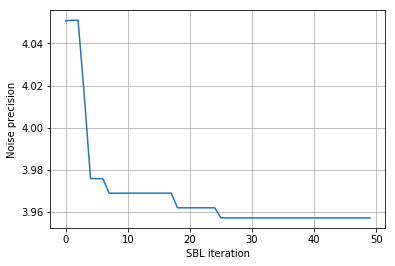

In [6]:
plt.figure(1)
for i in range(0,N): plt.plot(iterMean[i,:],label=str(i))
plt.grid(True)
plt.ylabel('Mean')
plt.xlabel('SBL iteration'); 
plt.ylim(Wlim)
plt.legend(loc='right', numpoints = 1);
plt.savefig('SBL_MEAN.eps',bbox_inches='tight')

plt.figure(2)
plt.plot(iterLogEvid)
plt.grid(True)
plt.ylabel('Log-evidence')
plt.xlabel('SBL iteration'); 
plt.savefig('SBL_LOGEVID.eps',bbox_inches='tight')

plt.figure(3)
plt.plot(iterRho)
plt.grid(True)
plt.ylabel('Noise precision')
plt.xlabel('SBL iteration'); 
plt.savefig('SBL_RHO.eps',bbox_inches='tight')
